In [57]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader


amazon = pd.read_csv('AMAZON_daily.csv')
amazon=amazon[['Date', 'Close']]

apple = pd.read_csv('APPLE_daily.csv')
apple=apple[['Date', 'Close']]

google = pd.read_csv('GOOGLE_daily.csv')
google=google[['Date', 'Close']]

meta = pd.read_csv('META_daily.csv')
meta=meta[['Date', 'Close']]

netflix = pd.read_csv('NETFLIX_daily.csv')
netflix=netflix[['Date', 'Close']]

#my GPU is AMD Radeon (too complicated to use on my computer)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'



In [58]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{n_steps+1-i})'] = df['Close'].shift(n_steps+1-i)

    df.dropna(inplace=True)

    return df

lookback=7
amazon_shift = prepare_dataframe_for_lstm(amazon, lookback)

apple_shift = prepare_dataframe_for_lstm(apple, lookback)

google_shift = prepare_dataframe_for_lstm(google, lookback)

meta_shift = prepare_dataframe_for_lstm(meta, lookback)

netflix_shift= prepare_dataframe_for_lstm(netflix, lookback)

netflix_shift

,Date,Close,Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
7,2002-06-04,1.117857,1.196429,1.210000,1.157143,1.103571,1.071429,1.076429,1.128571
8,2002-06-05,1.147143,1.210000,1.157143,1.103571,1.071429,1.076429,1.128571,1.117857
9,2002-06-06,1.182143,1.157143,1.103571,1.071429,1.076429,1.128571,1.117857,1.147143
10,2002-06-07,1.118571,1.103571,1.071429,1.076429,1.128571,1.117857,1.147143,1.182143
11,2002-06-10,1.156429,1.071429,1.076429,1.128571,1.117857,1.147143,1.182143,1.118571
...,...,...,...,...,...,...,...,...,...
5771,2025-04-30,1131.719971,987.909973,1040.339966,1049.589966,1096.869995,1101.530029,1110.380005,1125.640015
5772,2025-05-01,1133.469971,1040.339966,1049.589966,1096.869995,1101.530029,1110.380005,1125.640015,1131.719971
5773,2025-05-02,1156.489990,1049.589966,1096.869995,1101.530029,1110.380005,1125.640015,1131.719971,1133.469971
5774,2025-05-05,1134.060059,1096.869995,1101.530029,1110.380005,1125.640015,1131.719971,1133.469971,1156.489990


In [59]:
amazon_np = amazon_shift.to_numpy() # won't show date column since data is index
amazon_np= np.hstack((amazon_np, np.ones((len(amazon_np),1))))
amazon_np = np.hstack((amazon_np, np.zeros((len(amazon_np), 4))))

apple_np = apple_shift.to_numpy()
apple_np = np.hstack((apple_np, np.zeros((len(apple_np), 1))))
apple_np = np.hstack((apple_np, np.ones((len(apple_np), 1))))
apple_np = np.hstack((apple_np, np.zeros((len(apple_np), 3))))

google_np = google_shift.to_numpy()
google_np = np.hstack((google_np, np.zeros((len(google_np), 2))))
google_np = np.hstack((google_np, np.ones((len(google_np), 1))))
google_np = np.hstack((google_np, np.zeros((len(google_np), 2))))

meta_np = meta_shift.to_numpy()
meta_np = np.hstack((meta_np, np.zeros((len(meta_np), 3))))
meta_np = np.hstack((meta_np, np.ones((len(meta_np), 1))))
meta_np = np.hstack((meta_np, np.zeros((len(meta_np), 1))))

netflix_np = netflix_shift.to_numpy()
netflix_np = np.hstack((netflix_np, np.zeros((len(netflix_np),4))))
netflix_np = np.hstack((netflix_np, np.ones((len(netflix_np), 1))))

shifted_np = np.vstack((amazon_np, apple_np, google_np, meta_np, netflix_np))


In [60]:
first_day = np.datetime64('2013-01-01 00:00:00')
ind = shifted_np[:,0] >= first_day
shifted_np = shifted_np[ind]

cutoff_date = np.quantile(shifted_np[:,0],0.80)
test_ind = shifted_np[:,0] >= cutoff_date
train_ind = shifted_np[:,0] < cutoff_date

shifted_np = np.delete(shifted_np, 0, 1)


In [61]:
from sklearn.preprocessing import MinMaxScaler

scalery = MinMaxScaler(feature_range=(-1,1)) #video said feature_range=(-1,1)
#this does std = (x-min)(max-min), x_new = std*(min-max)+min

shifted_np[:,0] = (scalery.fit_transform(shifted_np[:,0].reshape(-1,1))).reshape(-1)

scalerx = MinMaxScaler(feature_range=(-1,1))
shifted_np[:,1:lookback+1] = scalerx.fit_transform(shifted_np[:,1:lookback+1])



In [62]:
X =shifted_np[:,1:]
y=shifted_np[:,0]

In [ ]:
#Spliting into train and test
X_train = X[train_ind]
X_test = X[test_ind]
y_train = y[train_ind]
y_test = y[test_ind]

#pytorch wants another dimension so:
X_train_np = (X_train.reshape((-1, lookback+5, 1))).astype(float)
X_test_np = (X_test.reshape((-1,lookback+5, 1))).astype(float)

y_train_np = (y_train.reshape((-1,1))).astype(float)
y_test_np = (y_test.reshape((-1,1))).astype(float)


In [64]:
#Wrap in tensors for pytorch
X_train = torch.tensor(X_train_np).float()
X_test = torch.tensor(X_test_np).float()
y_train = torch.tensor(y_train_np).float()
y_test = torch.tensor(y_test_np).float()

In [65]:
#Turn into dataset object (need custom class)
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X =X
        self.y =y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i): #square brackets indexing
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [66]:
#Wrap Datsets in DataLoaders to get batches

from torch.utils.data import DataLoader

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [67]:
##Building the model

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, lookback, num_lin_lay, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.lookback =lookback
        self.num_stacked_layers = num_stacked_layers
        self.num_lin_lay = num_lin_lay

        #need this for grid search
        effective_dropout = dropout if num_stacked_layers > 1 else 0.0

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, dropout=effective_dropout,batch_first=True)
        if num_lin_lay == 2:#num_lin_lay must be either 1 and 2
            self.fc2 = nn.Linear(hidden_size+5, hidden_size+5)        
        self.fc = nn.Linear(hidden_size+5, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #h0 is gate vectors, must initialize with particular shape
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x[:,:lookback],(h0, c0))
        temporary = torch.cat((out[:,-1,:], x[:, lookback:,0]), dim=1)
        
        if self.num_lin_lay ==2:
            temp2 = self.fc2(temporary)
            out = self.fc(temp2)
        else:
            out = self.fc(temporary)
        return out
    
model = LSTM(1,4,1, lookback, 1,0)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=9, out_features=1, bias=True)
)

In [68]:
##Training function
def train_one_epoch(m,epoch, optimizer, loss_function, trainload):
    m.train(True) #set to training mode
    print(f'Epoch: {epoch+1}')
    running_loss=0.0

    for batch_index, batch in enumerate(trainload):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) #gets a batch and puts on devide we use

        output = m(x_batch) #gets output of model
        loss = loss_function(output, y_batch) #compares outputs to ground truth
        running_loss += loss.item()
        optimizer.zero_grad() #zero out gradients
        loss.backward() #backward pass to calculate gradients
        optimizer.step() #slight step in direction of gradient

        if batch_index %100 ==99: #prints every 100 batches
            avg_loss = running_loss/100
            print('Batch {0}, Average Loss: {1:.10f}'.format(batch_index+1, avg_loss))

            running_loss=0.0 #reset back to 0
    print() #for a blank line space

In [69]:
##Validation function
def validate_one_epoch(m, loss_function, testload):
    m.train(False) #will not update weights
    running_loss=0.0

    for batch_index, batch in enumerate(testload):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): #set to not update weights or change model
            output = m(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss

    avg_loss = running_loss/len(testload)

    print('Validation loss:{0:.10f}'.format(avg_loss))
    print('**********************************************************') #looks good
    print() 
    return avg_loss

In [21]:
##Hyperparameters:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(model, epoch, optimizer, loss_function, train_loader) 
    validate_one_epoch(model,loss_function, test_loader)

Epoch: 1
Batch 100, Average Loss: 0.2146750726
Batch 200, Average Loss: 0.0453879638
Batch 300, Average Loss: 0.0311999355
Batch 400, Average Loss: 0.0230934259
Batch 500, Average Loss: 0.0163789824
Batch 600, Average Loss: 0.0109348227
Batch 700, Average Loss: 0.0072374914

Validation loss:0.0564559549
**********************************************************

Epoch: 2
Batch 100, Average Loss: 0.0036291276
Batch 200, Average Loss: 0.0027611399
Batch 300, Average Loss: 0.0020838697
Batch 400, Average Loss: 0.0016236685
Batch 500, Average Loss: 0.0010703010
Batch 600, Average Loss: 0.0014993869
Batch 700, Average Loss: 0.0010028316

Validation loss:0.0373282246
**********************************************************

Epoch: 3
Batch 100, Average Loss: 0.0011840428
Batch 200, Average Loss: 0.0006258486
Batch 300, Average Loss: 0.0007010112
Batch 400, Average Loss: 0.0007742340
Batch 500, Average Loss: 0.0004761590
Batch 600, Average Loss: 0.0005212009
Batch 700, Average Loss: 0.000431

In [22]:
##graphing stuff
ind_am = ((X_train[:,7,0]==1).nonzero()).reshape(-1)
x_am = X_train[ind_am]

ind_ap = ((X_train[:,8,0]==1).nonzero()).reshape(-1)
x_ap = X_train[ind_ap]

ind_go = ((X_train[:,9,0]==1).nonzero()).reshape(-1)
x_go = X_train[ind_go]

ind_me = ((X_train[:,10,0]==1).nonzero()).reshape(-1)
x_me = X_train[ind_me]

ind_ne = ((X_train[:,11,0]==1).nonzero()).reshape(-1)
x_ne = X_train[ind_ne]


with torch.no_grad():
    predicted_am = model(x_am.to(device)).to('cpu').numpy() #numpy doesn't work on GPU
    predicted_ap = model(x_ap.to(device)).to('cpu').numpy()
    predicted_go = model(x_go.to(device)).to('cpu').numpy()
    predicted_me = model(x_me.to(device)).to('cpu').numpy()
    predicted_ne = model(x_ne.to(device)).to('cpu').numpy()


In [23]:
##Must inverse transform because normalized data
train_pred_am = scalery.inverse_transform(predicted_am)
y_train_am = scalery.inverse_transform(y_train[ind_am]) # Do the same for ground truth
#apple
train_pred_ap = scalery.inverse_transform(predicted_ap)
y_train_ap = scalery.inverse_transform(y_train[ind_ap])
#Google
train_pred_go = scalery.inverse_transform(predicted_go)
y_train_go = scalery.inverse_transform(y_train[ind_go])
#meta
train_pred_me = scalery.inverse_transform(predicted_me)
y_train_me = scalery.inverse_transform(y_train[ind_me])
#netflix
train_pred_ne = scalery.inverse_transform(predicted_ne)
y_train_ne = scalery.inverse_transform(y_train[ind_ne])

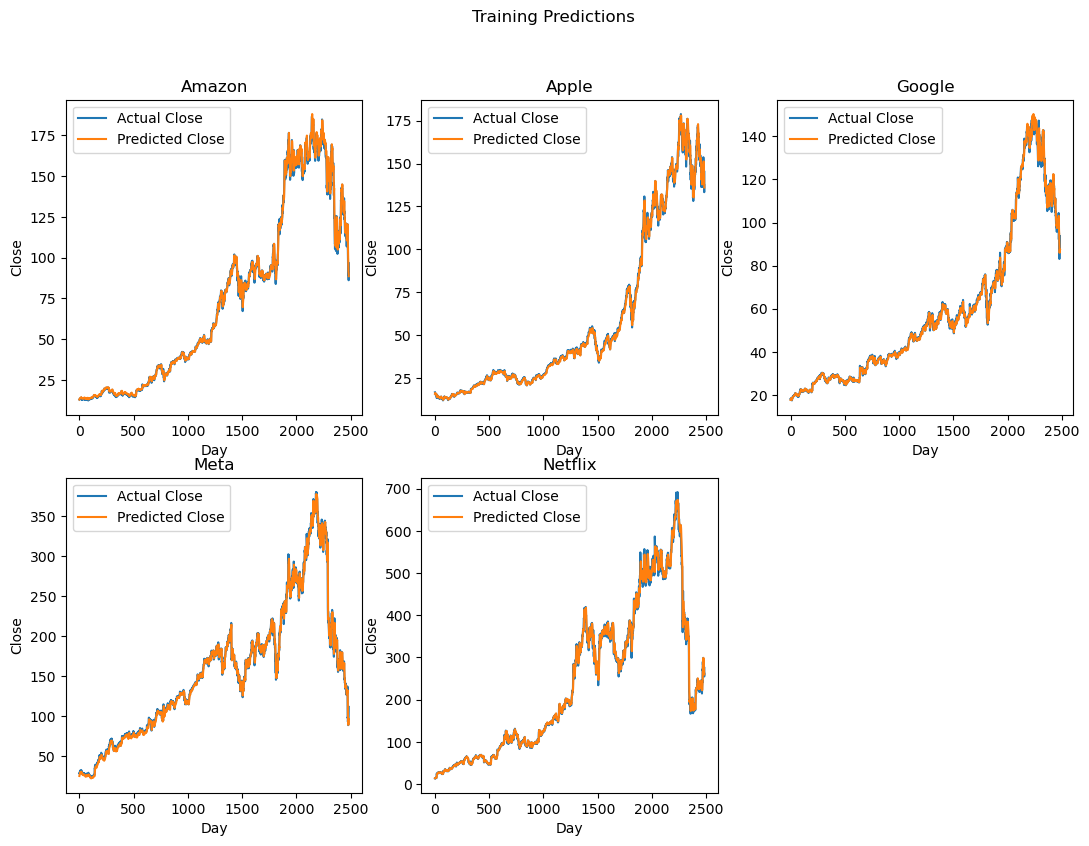

In [24]:
plt.figure(figsize=(13,9))
plt.subplot(2,3,1)
plt.plot(y_train_am, label='Actual Close')
plt.plot(train_pred_am, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Amazon')
plt.legend()
plt.subplot(2,3,2)
plt.plot(y_train_ap, label='Actual Close')
plt.plot(train_pred_ap, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Apple')
plt.legend()
plt.subplot(2,3,3)
plt.plot(y_train_go, label='Actual Close')
plt.plot(train_pred_go, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Google')
plt.legend()
plt.subplot(2,3,4)
plt.plot(y_train_me, label='Actual Close')
plt.plot(train_pred_me, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Meta')
plt.legend()
plt.subplot(2,3,5)
plt.plot(y_train_ne, label='Actual Close')
plt.plot(train_pred_ne, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Netflix')
plt.legend()
plt.suptitle('Training Predictions')
plt.show()

In [25]:
#now do this for testing (finding the proper scale)
ind_am_test = ((X_test[:,7,0]==1).nonzero()).reshape(-1)
x_am_test = X_test[ind_am_test]

ind_ap_test = ((X_test[:,8,0]==1).nonzero()).reshape(-1)
x_ap_test = X_test[ind_ap_test]

ind_go_test = ((X_test[:,9,0]==1).nonzero()).reshape(-1)
x_go_test = X_test[ind_go_test]

ind_me_test = ((X_test[:,10,0]==1).nonzero()).reshape(-1)
x_me_test = X_test[ind_me_test]

ind_ne_test = ((X_test[:,11,0]==1).nonzero()).reshape(-1)
x_ne_test = X_test[ind_ne_test]

#predicted_test_am = model(x_am_test.to(device)).detach().cpu().numpy().flatten() #from video
with torch.no_grad():
    predicted_test_am = model(x_am_test.to(device)).to('cpu').numpy() #numpy doesn't work on GPU
    predicted_test_ap = model(x_ap_test.to(device)).to('cpu').numpy()
    predicted_test_go = model(x_go_test.to(device)).to('cpu').numpy()
    predicted_test_me = model(x_me_test.to(device)).to('cpu').numpy()
    predicted_test_ne = model(x_ne_test.to(device)).to('cpu').numpy()

predicted_test_am = scalery.inverse_transform(predicted_test_am)
y_test_am = scalery.inverse_transform(y_test[ind_am_test])

predicted_test_ap = scalery.inverse_transform(predicted_test_ap)
y_test_ap = scalery.inverse_transform(y_test[ind_ap_test])

predicted_test_go = scalery.inverse_transform(predicted_test_go)
y_test_go = scalery.inverse_transform(y_test[ind_go_test])

predicted_test_me = scalery.inverse_transform(predicted_test_me)
y_test_me = scalery.inverse_transform(y_test[ind_me_test])

predicted_test_ne = scalery.inverse_transform(predicted_test_ne)
y_test_ne = scalery.inverse_transform(y_test[ind_ne_test])

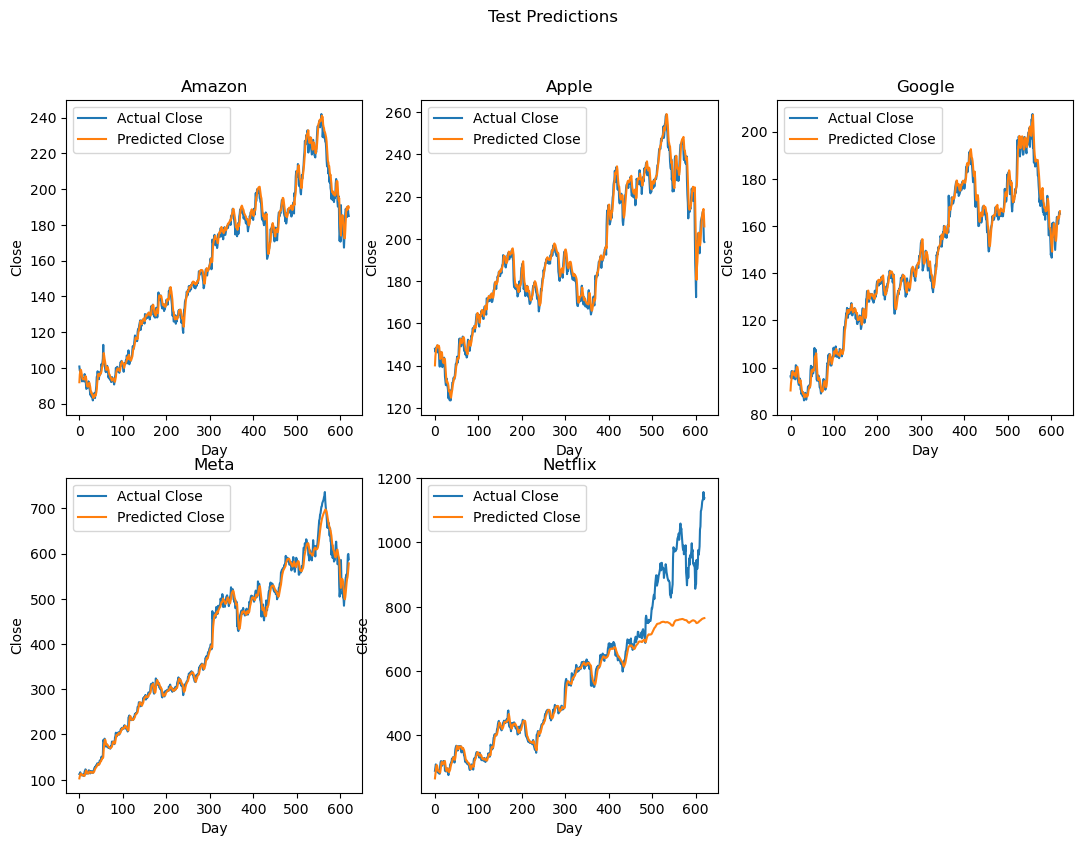

In [26]:
plt.figure(figsize=(13,9))
plt.subplot(2,3,1)
plt.plot(y_test_am, label='Actual Close')
plt.plot(predicted_test_am, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Amazon')
plt.legend()
plt.subplot(2,3,2)
plt.plot(y_test_ap, label='Actual Close')
plt.plot(predicted_test_ap, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Apple')
plt.legend()
plt.subplot(2,3,3)
plt.plot(y_test_go, label='Actual Close')
plt.plot(predicted_test_go, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Google')
plt.legend()
plt.subplot(2,3,4)
plt.plot(y_test_me, label='Actual Close')
plt.plot(predicted_test_me, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Meta')
plt.legend()
plt.subplot(2,3,5)
plt.plot(y_test_ne, label='Actual Close')
plt.plot(predicted_test_ne, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Netflix')
plt.legend()
plt.suptitle('Test Predictions')
plt.show()

In [47]:
path = 'model.pth'
torch.save(model.state_dict(), path)

_____________________________________________________________________________________________________________________________________

In [50]:
##Predicting with weeks instead, using the average of 5 days as the week (no data collected on weekends)

def find_avg_weeks(X, days):
    length = len(X)//days
    X['Date'] = pd.to_datetime(X['Date'])
    new_X = []
    for i in range(length):
        new_X.append(X.iloc[days*i:days*i+days,:].mean())
    return pd.DataFrame(new_X).reset_index(drop=True)

amazon_week = find_avg_weeks(amazon, 5)
apple_week =find_avg_weeks(apple,5)
google_week = find_avg_weeks(apple,5)
meta_week = find_avg_weeks(meta, 5)
netflix_week = find_avg_weeks(netflix, 5)

In [51]:
lookback=7
amazon_week_shift = prepare_dataframe_for_lstm(amazon_week, lookback)
apple_week_shift = prepare_dataframe_for_lstm(apple_week, lookback)
google_week_shift = prepare_dataframe_for_lstm(google_week, lookback)
meta_week_shift = prepare_dataframe_for_lstm(meta_week, lookback)
netflix_week_shift = prepare_dataframe_for_lstm(netflix_week, lookback)

netflix_week_shift

,Date,Close,Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
7,2002-07-17 00:00:00,1.133572,1.147714,1.130429,1.120857,0.945572,0.970857,1.138143,1.195428
8,2002-07-24 00:00:00,1.067857,1.130429,1.120857,0.945572,0.970857,1.138143,1.195428,1.133572
9,2002-07-31 00:00:00,0.882714,1.120857,0.945572,0.970857,1.138143,1.195428,1.133572,1.067857
10,2002-08-07 00:00:00,0.782571,0.945572,0.970857,1.138143,1.195428,1.133572,1.067857,0.882714
11,2002-08-14 00:00:00,0.831857,0.970857,1.138143,1.195428,1.133572,1.067857,0.882714,0.782571
...,...,...,...,...,...,...,...,...,...
1150,2025-04-02 00:00:00,913.868005,1024.121997,1033.093994,979.879993,946.933997,897.925989,950.123999,970.097998
1151,2025-04-09 00:00:00,904.631995,1033.093994,979.879993,946.933997,897.925989,950.123999,970.097998,913.868005
1152,2025-04-16 14:24:00,966.026013,979.879993,946.933997,897.925989,950.123999,970.097998,913.868005,904.631995
1153,2025-04-24 09:36:00,1079.741992,946.933997,897.925989,950.123999,970.097998,913.868005,904.631995,966.026013


In [52]:
##Adding one hot encoding (again)
amazon_week_np = amazon_week_shift.to_numpy() # won't show date column since data is index
amazon_week_np= np.hstack((amazon_week_np, np.ones((len(amazon_week_np),1))))
amazon_week_np = np.hstack((amazon_week_np, np.zeros((len(amazon_week_np), 4))))

apple_week_np = apple_week_shift.to_numpy()
apple_week_np = np.hstack((apple_week_np, np.zeros((len(apple_week_np), 1))))
apple_week_np = np.hstack((apple_week_np, np.ones((len(apple_week_np), 1))))
apple_week_np = np.hstack((apple_week_np, np.zeros((len(apple_week_np), 3))))

google_week_np = google_week_shift.to_numpy()
google_week_np = np.hstack((google_week_np, np.zeros((len(google_week_np), 2))))
google_week_np = np.hstack((google_week_np, np.ones((len(google_week_np), 1))))
google_week_np = np.hstack((google_week_np, np.zeros((len(google_week_np), 2))))

meta_week_np = meta_week_shift.to_numpy()
meta_week_np = np.hstack((meta_week_np, np.zeros((len(meta_week_np), 3))))
meta_week_np = np.hstack((meta_week_np, np.ones((len(meta_week_np), 1))))
meta_week_np = np.hstack((meta_week_np, np.zeros((len(meta_week_np), 1))))

netflix_week_np = netflix_week_shift.to_numpy()
netflix_week_np = np.hstack((netflix_week_np, np.zeros((len(netflix_week_np),4))))
netflix_week_np = np.hstack((netflix_week_np, np.ones((len(netflix_week_np), 1))))

shifted_week_np = np.vstack((amazon_week_np, apple_week_np, google_week_np, meta_week_np, netflix_week_np))
shifted_week_np[:,0]

array([Timestamp('1997-07-09 00:00:00'), Timestamp('1997-07-16 00:00:00'),
       Timestamp('1997-07-23 00:00:00'), ...,
       Timestamp('2025-04-16 14:24:00'), Timestamp('2025-04-24 09:36:00'),
       Timestamp('2025-05-01 09:36:00')], dtype=object)

In [53]:
#only after 2013
first_week = np.datetime64('2013-01-01 00:00:00')
ind_week = shifted_week_np[:,0] >= first_week
shifted_week_np = shifted_week_np[ind_week]

#split the dataset
cutoff_date_week = np.quantile(shifted_week_np[:,0],0.8)
test_ind_week = shifted_week_np[:,0] >= cutoff_date_week
train_ind_week = shifted_week_np[:,0] < cutoff_date_week

shifted_week_np = np.delete(shifted_week_np, 0, 1)

#Normalize
from sklearn.preprocessing import MinMaxScaler

scaler_weeky = MinMaxScaler(feature_range=(-1,1)) #video said feature_range=(-1,1)
#this does std = (x-min)(max-min), x_new = std*(min-max)+min

shifted_week_np[:,0] = (scaler_weeky.fit_transform(shifted_week_np[:,0].reshape(-1,1))).reshape(-1)

scaler_weekx = MinMaxScaler(feature_range=(-1,1))
shifted_week_np[:,1:lookback+1] = scaler_weekx.fit_transform(shifted_week_np[:,1:lookback+1])



In [54]:
# Define X,y, and split into training and testing
X_week =shifted_week_np[:,1:]
y_week=shifted_week_np[:,0]

#Spliting into train and test
X_week_train = X_week[train_ind_week]
X_week_test = X_week[test_ind_week]
y_week_train = y_week[train_ind_week]
y_week_test = y_week[test_ind_week]


#pytorch wants another dimension so:
X_week_train_np = (X_week_train.reshape((-1, lookback+5, 1))).astype(float)
X_week_test_np = (X_week_test.reshape((-1,lookback+5, 1))).astype(float)

y_week_train_np = (y_week_train.reshape((-1,1))).astype(float)
y_week_test_np = (y_week_test.reshape((-1,1))).astype(float)


In [55]:
#Wrap in tensors for pytorch
X_week_train = torch.tensor(X_week_train_np).float()
X_week_test = torch.tensor(X_week_test_np).float()
y_week_train = torch.tensor(y_week_train_np).float()
y_week_test = torch.tensor(y_week_test_np).float()

#Wrap in dataset defined above
train_week_dataset = TimeSeriesDataset(X_week_train, y_week_train)
test_week_dataset = TimeSeriesDataset(X_week_test, y_week_test)

#Put into dataloader
from torch.utils.data import DataLoader

batch_size=16
train_week_loader = DataLoader(train_week_dataset, batch_size=batch_size, shuffle=True)
test_week_loader = DataLoader(test_week_dataset, batch_size = batch_size, shuffle=False)

In [67]:
model_week = LSTM(1,4,1, lookback, 1,0)
model_week.to(device)
model_week

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=9, out_features=1, bias=True)
)

In [55]:
#Training
##Hyperparameters:
learning_rate = 0.001
num_epochs = 25
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_week.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(model_week,epoch, optimizer, loss_function, train_week_loader) 
    validate_one_epoch(model_week, loss_function, test_week_loader)

Epoch: 1
Batch 100, Average Loss: 0.5918009067

Validation loss:0.2839962840
**********************************************************

Epoch: 2
Batch 100, Average Loss: 0.0413831365

Validation loss:0.1590586156
**********************************************************

Epoch: 3
Batch 100, Average Loss: 0.0109869943

Validation loss:0.1032684296
**********************************************************

Epoch: 4
Batch 100, Average Loss: 0.0029524440

Validation loss:0.0898646787
**********************************************************

Epoch: 5
Batch 100, Average Loss: 0.0018911766

Validation loss:0.0856452584
**********************************************************

Epoch: 6
Batch 100, Average Loss: 0.0013098135

Validation loss:0.0840619653
**********************************************************

Epoch: 7
Batch 100, Average Loss: 0.0013484964

Validation loss:0.0822223499
**********************************************************

Epoch: 8
Batch 100, Average Loss: 0.00136

In [56]:
##graphing stuff
ind_week_am = ((X_week_train[:,7,0]==1).nonzero()).reshape(-1)
x_week_am = X_week_train[ind_week_am]

ind_week_ap = ((X_week_train[:,8,0]==1).nonzero()).reshape(-1)
x_week_ap = X_week_train[ind_week_ap]

ind_week_go = ((X_week_train[:,9,0]==1).nonzero()).reshape(-1)
x_week_go = X_week_train[ind_week_go]

ind_week_me = ((X_week_train[:,10,0]==1).nonzero()).reshape(-1)
x_week_me = X_week_train[ind_week_me]

ind_week_ne = ((X_week_train[:,11,0]==1).nonzero()).reshape(-1)
x_week_ne = X_week_train[ind_week_ne]


with torch.no_grad():
    predicted_week_am = model_week(x_week_am.to(device)).to('cpu').numpy() #numpy doesn't work on GPU
    predicted_week_ap = model_week(x_week_ap.to(device)).to('cpu').numpy()
    predicted_week_go = model_week(x_week_go.to(device)).to('cpu').numpy()
    predicted_week_me = model_week(x_week_me.to(device)).to('cpu').numpy()
    predicted_week_ne = model_week(x_week_ne.to(device)).to('cpu').numpy()

##Must inverse transform because normalized data
train_pred_week_am = scaler_weeky.inverse_transform(predicted_week_am)
y_train_week_am = scaler_weeky.inverse_transform(y_week_train[ind_week_am]) # Do the same for ground truth
#apple
train_pred_week_ap = scaler_weeky.inverse_transform(predicted_week_ap)
y_train_week_ap = scaler_weeky.inverse_transform(y_week_train[ind_week_ap])
#Google
train_pred_week_go = scaler_weeky.inverse_transform(predicted_week_go)
y_train_week_go = scaler_weeky.inverse_transform(y_week_train[ind_week_go])
#meta
train_pred_week_me = scaler_weeky.inverse_transform(predicted_week_me)
y_train_week_me = scaler_weeky.inverse_transform(y_week_train[ind_week_me])
#netflix
train_pred_week_ne = scaler_weeky.inverse_transform(predicted_week_ne)
y_train_week_ne = scaler_weeky.inverse_transform(y_week_train[ind_week_ne])

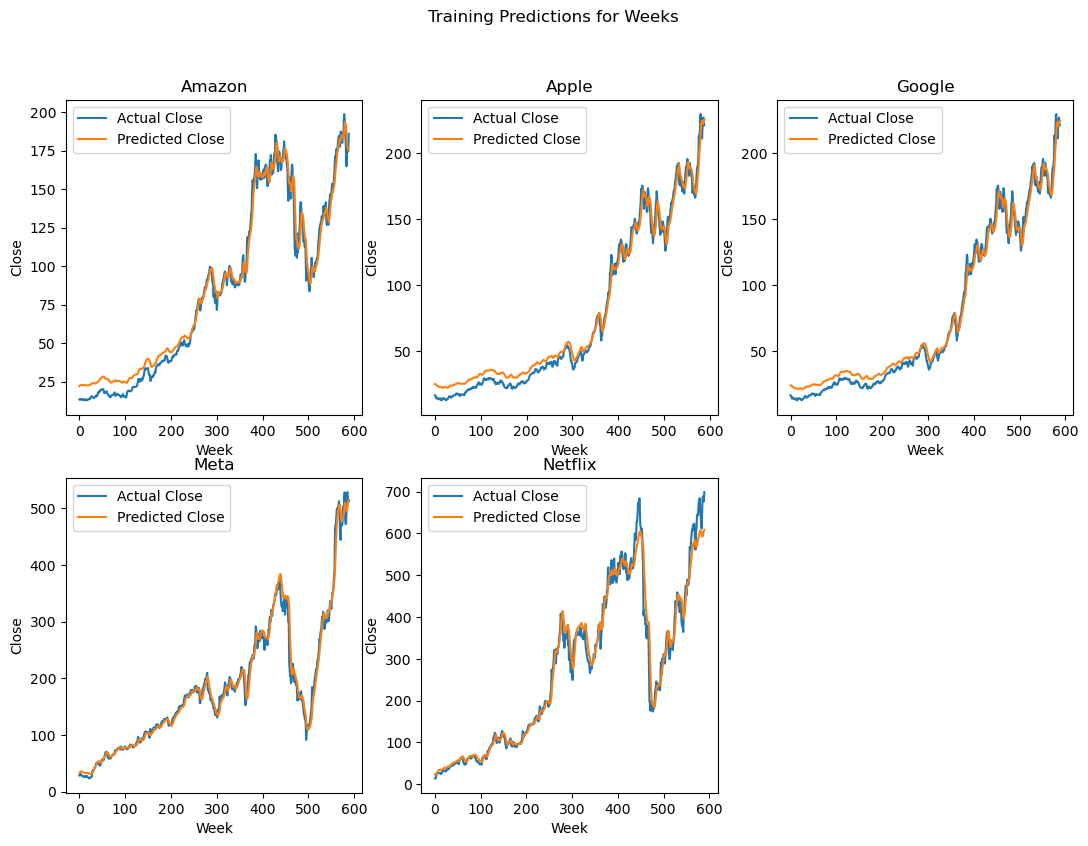

In [57]:
#Graphing Training
plt.figure(figsize=(13,9))
plt.subplot(2,3,1)
plt.plot(y_train_week_am, label='Actual Close')
plt.plot(train_pred_week_am, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Amazon')
plt.legend()
plt.subplot(2,3,2)
plt.plot(y_train_week_ap, label='Actual Close')
plt.plot(train_pred_week_ap, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Apple')
plt.legend()
plt.subplot(2,3,3)
plt.plot(y_train_week_go, label='Actual Close')
plt.plot(train_pred_week_go, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Google')
plt.legend()
plt.subplot(2,3,4)
plt.plot(y_train_week_me, label='Actual Close')
plt.plot(train_pred_week_me, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Meta')
plt.legend()
plt.subplot(2,3,5)
plt.plot(y_train_week_ne, label='Actual Close')
plt.plot(train_pred_week_ne, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Netflix')
plt.legend()
plt.suptitle('Training Predictions for Weeks')
plt.show()

In [58]:
##graphing stuff
ind_test_week_am = ((X_week_test[:,7,0]==1).nonzero()).reshape(-1)
x_test_week_am = X_week_test[ind_test_week_am]

ind_test_week_ap = ((X_week_test[:,8,0]==1).nonzero()).reshape(-1)
x_test_week_ap = X_week_test[ind_test_week_ap]

ind_test_week_go = ((X_week_test[:,9,0]==1).nonzero()).reshape(-1)
x_test_week_go = X_week_test[ind_test_week_go]

ind_test_week_me = ((X_week_test[:,10,0]==1).nonzero()).reshape(-1)
x_test_week_me = X_week_test[ind_test_week_me]

ind_test_week_ne = ((X_week_test[:,11,0]==1).nonzero()).reshape(-1)
x_test_week_ne = X_week_test[ind_test_week_ne]


with torch.no_grad():
    predicted_test_week_am = model_week(x_test_week_am.to(device)).to('cpu').numpy() #numpy doesn't work on GPU
    predicted_test_week_ap = model_week(x_test_week_ap.to(device)).to('cpu').numpy()
    predicted_test_week_go = model_week(x_test_week_go.to(device)).to('cpu').numpy()
    predicted_test_week_me = model_week(x_test_week_me.to(device)).to('cpu').numpy()
    predicted_test_week_ne = model_week(x_test_week_ne.to(device)).to('cpu').numpy()

##Must inverse transform because normalized data
test_pred_week_am = scaler_weeky.inverse_transform(predicted_test_week_am)
y_test_week_am = scaler_weeky.inverse_transform(y_week_test[ind_test_week_am]) # Do the same for ground truth
#apple
test_pred_week_ap = scaler_weeky.inverse_transform(predicted_test_week_ap)
y_test_week_ap = scaler_weeky.inverse_transform(y_week_test[ind_test_week_ap])
#Google
test_pred_week_go = scaler_weeky.inverse_transform(predicted_test_week_go)
y_test_week_go = scaler_weeky.inverse_transform(y_week_test[ind_test_week_go])
#meta
test_pred_week_me = scaler_weeky.inverse_transform(predicted_test_week_me)
y_test_week_me = scaler_weeky.inverse_transform(y_week_test[ind_test_week_me])
#netflix
test_pred_week_ne = scaler_weeky.inverse_transform(predicted_test_week_ne)
y_test_week_ne = scaler_weeky.inverse_transform(y_week_test[ind_test_week_ne])

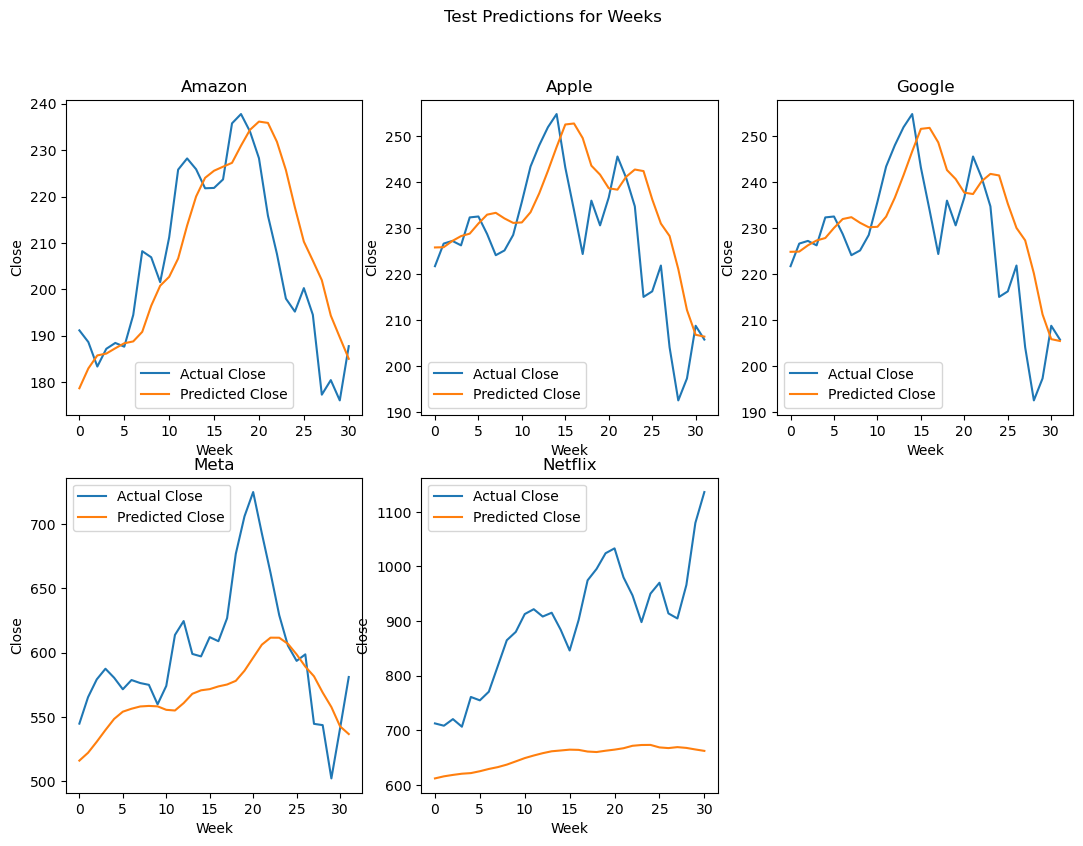

In [59]:
#Graphing Testing
plt.figure(figsize=(13,9))
plt.subplot(2,3,1)
plt.plot(y_test_week_am, label='Actual Close')
plt.plot(test_pred_week_am, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Amazon')
plt.legend()
plt.subplot(2,3,2)
plt.plot(y_test_week_ap, label='Actual Close')
plt.plot(test_pred_week_ap, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Apple')
plt.legend()
plt.subplot(2,3,3)
plt.plot(y_test_week_go, label='Actual Close')
plt.plot(test_pred_week_go, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Google')
plt.legend()
plt.subplot(2,3,4)
plt.plot(y_test_week_me, label='Actual Close')
plt.plot(test_pred_week_me, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Meta')
plt.legend()
plt.subplot(2,3,5)
plt.plot(y_test_week_ne, label='Actual Close')
plt.plot(test_pred_week_ne, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Netflix')
plt.legend()
plt.suptitle('Test Predictions for Weeks')
plt.show()

In [60]:
path = 'model_week.pth'
torch.save(model_week.state_dict(), path)

_____________________________________________________________________________________________________________________________________

In [85]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EarlyStopping, Checkpoint

lstm = NeuralNetRegressor(LSTM
                         , max_epochs = 10 #can increase later once have best params
                         , lr=0.001
                         , verbose=1
                         , criterion=nn.MSELoss
                         , optimizer = torch.optim.Adam
                         , module__lookback=7
                         , optimizer__weight_decay=0.001
                         , module__input_size=1 #default
                         , callbacks=[EarlyStopping(monitor='valid_loss', patience=3)]
                         , device='cuda' if torch.cuda.is_available() else 'cpu')

#grid search

param_grid ={
    'lr': [0.001, 0.01],
    'batch_size': [16, 32],
    'module__hidden_size':[4,32],
    'module__num_stacked_layers':[1,2],
    'module__num_lin_lay': [1,2], #must either be 1 or 2
    'optimizer__weight_decay': [0.001, 0],
    'module__dropout': [0.2, 0.5]
}

#hyperparameter tuning on 
gs = GridSearchCV(lstm, param_grid, scoring='neg_mean_squared_error', verbose=3, cv=3)

#got an error
X_train_np = X_train_np.astype(np.float32)
y_train_np = y_train_np.astype(np.float32)

gs.fit(X_train_np, y_train_np)


Fitting 3 folds for each of 128 candidates, totalling 384 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1010        0.1743  1.7171
      2        0.0251        0.0916  1.1412
      3        0.0147        0.0342  1.2028
      4        0.0088        0.0090  1.1078
      5        0.0057        0.0018  1.1136
      6        0.0040        0.0007  1.2435
      7        0.0031        0.0010  1.1064
      8        0.0025        0.0015  1.1269
Stopping since valid_loss has not improved in the last 3 epochs.
[CV 1/3] END batch_size=16, lr=0.001, module__dropout=0.2, module__hidden_size=4, module__num_lin_lay=1, module__num_stacked_layers=1, optimizer__weight_decay=0.001;, score=-0.003 total time=  11.5s
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2091        0.0776  1.5573
      2        0.0089        0.0158  1.5552
      3        0.0044        0.0033  1.3076
      4      

GridSearchCV(cv=3,
             estimator=NeuralNetRegressor(_params_to_validate={'optimizer__weight_decay', 'module__input_size', 'module__lookback'}, batch_size=128, callbacks=[<skorch.callbacks.training.EarlyStopping object at 0x000001EBDFCB5EA0>], compile=False, dataset=<class 'skorch.dataset.Dataset'>, device='cpu', iterator_train=<class 'torch.utils.data.dataloader.Dat...korch.dataset.ValidSplit object at 0x000001EBDF93B640>, use_caching='auto', verbose=1, warm_start=False),
             param_grid={'batch_size': [16, 32], 'lr': [0.001, 0.01],
                         'module__dropout': [0.2, 0.5],
                         'module__hidden_size': [4, 32],
                         'module__num_lin_lay': [1, 2],
                         'module__num_stacked_layers': [1, 2],
                         'optimizer__weight_decay': [0.001, 0]},
             scoring='neg_mean_squared_error', verbose=3)

In [86]:
# After fitting
print("Best parameters found:")
print(gs.best_params_)

print(f"Best MSE score: {-gs.best_score_:.4f}")

# You can also get the best estimator itself (the model trained with the best params)
best_model = gs.best_estimator_.module_

path = 'model_best_day.pth'
torch.save(best_model.state_dict(), path)


Best parameters found:
{'batch_size': 32, 'lr': 0.001, 'module__dropout': 0.2, 'module__hidden_size': 32, 'module__num_lin_lay': 1, 'module__num_stacked_layers': 1, 'optimizer__weight_decay': 0.001}
Best MSE score: 0.0184


Grid Search Attempt 1:

Best parameters found:
{'batch_size': 64, 'lr': 0.001, 'module__dropout': 0.5, 'module__hidden_size': 8, 'module__lookback': 5, 'module__num_lin_lay': 1, 'module__num_stacked_layers': 1, 'optimizer__weight_decay': 0.01}
Best R^2 score: 0.4377
Best MSE Score: MSE:0.009806988760828972

Graphs on testing data look worse than model above. Most likely mse is a better criterion than R2 score.

Grid Search Attempt 2:
Best parameters found:
{'batch_size': 32, 'lr': 0.001, 'module__dropout': 0.5, 'module__hidden_size': 4, 'module__lookback': 10, 'module__num_lin_lay': 1, 'module__num_stacked_layers': 1, 'optimizer__weight_decay': 0.001}
Best MSE score: 0.0160

Realized that lookback is decided when preparing the data, so it is not a hyperparameter that I can iterate over since I already have lookback=7 when setting up the model. Perhaps this is why the model did not fit well. 

Third Attempt:
Best parameters found:
{'batch_size': 32, 'lr': 0.001, 'module__dropout': 0.2, 'module__hidden_size': 32, 'module__num_lin_lay': 1, 'module__num_stacked_layers': 1, 'optimizer__weight_decay': 0.001}
Best MSE score: 0.0190


In [87]:
#now do this for testing (finding the proper scale)
ind_am_test = ((X_test[:,7,0]==1).nonzero()).reshape(-1)
x_am_test = X_test[ind_am_test]

ind_ap_test = ((X_test[:,8,0]==1).nonzero()).reshape(-1)
x_ap_test = X_test[ind_ap_test]

ind_go_test = ((X_test[:,9,0]==1).nonzero()).reshape(-1)
x_go_test = X_test[ind_go_test]

ind_me_test = ((X_test[:,10,0]==1).nonzero()).reshape(-1)
x_me_test = X_test[ind_me_test]

ind_ne_test = ((X_test[:,11,0]==1).nonzero()).reshape(-1)
x_ne_test = X_test[ind_ne_test]

#generating predictions with model
with torch.no_grad():
    y_pred = best_model(X_test.to(device)).to('cpu').numpy()
    predicted_test_am = best_model(x_am_test.to(device)).to('cpu').numpy() #numpy doesn't work on GPU
    predicted_test_ap = best_model(x_ap_test.to(device)).to('cpu').numpy()
    predicted_test_go = best_model(x_go_test.to(device)).to('cpu').numpy()
    predicted_test_me = best_model(x_me_test.to(device)).to('cpu').numpy()
    predicted_test_ne = best_model(x_ne_test.to(device)).to('cpu').numpy()

from sklearn.metrics import mean_squared_error
print('MSE:{}'.format(mean_squared_error(y_pred,y_test)))

predicted_test_am = scalery.inverse_transform(predicted_test_am)
y_test_am = scalery.inverse_transform(y_test[ind_am_test])

predicted_test_ap = scalery.inverse_transform(predicted_test_ap)
y_test_ap = scalery.inverse_transform(y_test[ind_ap_test])

predicted_test_go = scalery.inverse_transform(predicted_test_go)
y_test_go = scalery.inverse_transform(y_test[ind_go_test])

predicted_test_me = scalery.inverse_transform(predicted_test_me)
y_test_me = scalery.inverse_transform(y_test[ind_me_test])

predicted_test_ne = scalery.inverse_transform(predicted_test_ne)
y_test_ne = scalery.inverse_transform(y_test[ind_ne_test])

MSE:0.008241349831223488


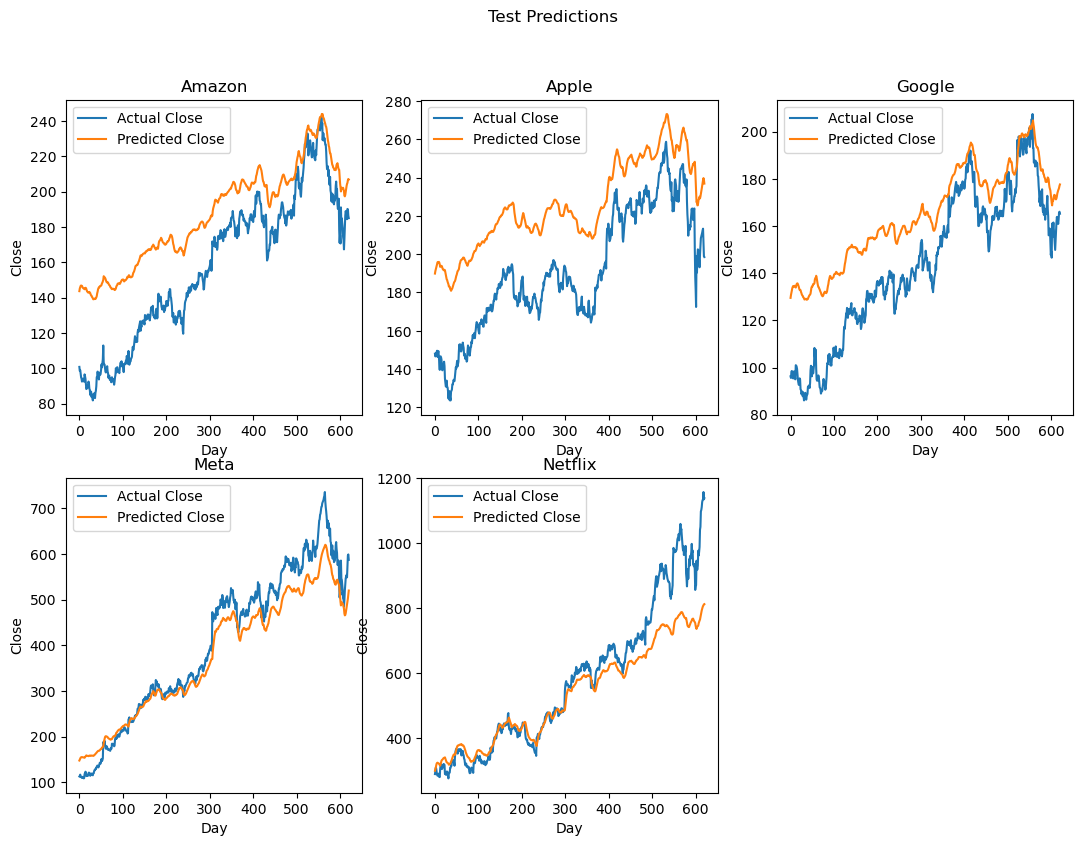

In [88]:
plt.figure(figsize=(13,9))
plt.subplot(2,3,1)
plt.plot(y_test_am, label='Actual Close')
plt.plot(predicted_test_am, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Amazon')
plt.legend()
plt.subplot(2,3,2)
plt.plot(y_test_ap, label='Actual Close')
plt.plot(predicted_test_ap, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Apple')
plt.legend()
plt.subplot(2,3,3)
plt.plot(y_test_go, label='Actual Close')
plt.plot(predicted_test_go, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Google')
plt.legend()
plt.subplot(2,3,4)
plt.plot(y_test_me, label='Actual Close')
plt.plot(predicted_test_me, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Meta')
plt.legend()
plt.subplot(2,3,5)
plt.plot(y_test_ne, label='Actual Close')
plt.plot(predicted_test_ne, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Netflix')
plt.legend()
plt.suptitle('Test Predictions')
plt.show()

In [ ]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EarlyStopping, Checkpoint

lstm_week = NeuralNetRegressor(LSTM
                         , max_epochs = 10 #can increase later once have best params
                         , lr=0.001
                         , verbose=1
                         , criterion=nn.MSELoss
                         , optimizer = torch.optim.Adam
                         , module__lookback=7
                         , optimizer__weight_decay=0.01
                         , module__input_size=1 #default
                         , callbacks=[EarlyStopping(monitor='valid_loss', patience=3)]
                         , device='cuda' if torch.cuda.is_available() else 'cpu')

#grid search

param_grid ={
    'lr': [0.001, 0.01],
    'batch_size': [16, 32],
    'module__hidden_size':[4,32],
    'module__num_stacked_layers':[1,2],
    'module__num_lin_lay': [1,2], #must either be 1 or 2
    'optimizer__weight_decay': [0.01, 0.001],
    'module__dropout': [0.2,0.5]
}

#hyperparameter tuning on 
gs_week = GridSearchCV(lstm_week, param_grid, scoring='neg_mean_squared_error', verbose=3, cv=3)

#got an error
X_week_train_np = X_week_train_np.astype(np.float32)
y_week_train_np = y_week_train_np.astype(np.float32)

gs_week.fit(X_week_train_np, y_week_train_np)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0745        0.0886  0.3548
      2        0.0433        0.0445  0.2366
      3        0.0381        0.0294  0.2447
      4        0.0340        0.0205  0.2289
      5        0.0290        0.0139  0.2332
      6        0.0231        0.0088  0.2177
      7        0.0173        0.0056  0.2147
      8        0.0126        0.0040  0.2274
      9        0.0093        0.0027  0.2377
     10        0.0072        0.0015  0.2243
[CV 1/3] END batch_size=16, lr=0.001, module__dropout=0.2, module__hidden_size=4, module__num_lin_lay=1, module__num_stacked_layers=1, optimizer__weight_decay=0.01;, score=-0.007 total time=   2.4s
[CV 2/3] END batch_size=16, lr=0.001, module__dropout=0.2, module__hidden_size=4, module__num_lin_lay=1, module__num_stacked_layers=1, optimizer__weight_decay=0.01;, score=-0.396 total time=   0.1s
  epoch    tr

In [33]:
# After fitting
print("Best parameters found:")
print(gs_week.best_params_)

print(f"Best MSE score: {-gs_week.best_score_:.4f}")

# You can also get the best estimator itself (the model trained with the best params)
best_model_week = gs_week.best_estimator_.module_

path = 'model_best_week.pth'
torch.save(best_model_week.state_dict(), path)

Best parameters found:
{'batch_size': 16, 'lr': 0.001, 'module__dropout': 0.5, 'module__hidden_size': 32, 'module__num_lin_lay': 1, 'module__num_stacked_layers': 1, 'optimizer__weight_decay': 0.001}
Best MSE score: 0.0156


Best parameters found:
{'batch_size': 16, 'lr': 0.001, 'module__dropout': 0.5, 'module__hidden_size': 32, 'module__num_lin_lay': 1, 'module__num_stacked_layers': 1, 'optimizer__weight_decay': 0.001}
Best MSE score: 0.0156

In [34]:
##graphing stuff
ind_test_week_am = ((X_week_test[:,7,0]==1).nonzero()).reshape(-1)
x_test_week_am = X_week_test[ind_test_week_am]

ind_test_week_ap = ((X_week_test[:,8,0]==1).nonzero()).reshape(-1)
x_test_week_ap = X_week_test[ind_test_week_ap]

ind_test_week_go = ((X_week_test[:,9,0]==1).nonzero()).reshape(-1)
x_test_week_go = X_week_test[ind_test_week_go]

ind_test_week_me = ((X_week_test[:,10,0]==1).nonzero()).reshape(-1)
x_test_week_me = X_week_test[ind_test_week_me]

ind_test_week_ne = ((X_week_test[:,11,0]==1).nonzero()).reshape(-1)
x_test_week_ne = X_week_test[ind_test_week_ne]


with torch.no_grad():
    predicted_test_week_am = best_model_week(x_test_week_am.to(device)).to('cpu').numpy() #numpy doesn't work on GPU
    predicted_test_week_ap = best_model_week(x_test_week_ap.to(device)).to('cpu').numpy()
    predicted_test_week_go = best_model_week(x_test_week_go.to(device)).to('cpu').numpy()
    predicted_test_week_me = best_model_week(x_test_week_me.to(device)).to('cpu').numpy()
    predicted_test_week_ne = best_model_week(x_test_week_ne.to(device)).to('cpu').numpy()

##Must inverse transform because normalized data
test_pred_week_am = scaler_weeky.inverse_transform(predicted_test_week_am)
y_test_week_am = scaler_weeky.inverse_transform(y_week_test[ind_test_week_am]) # Do the same for ground truth
#apple
test_pred_week_ap = scaler_weeky.inverse_transform(predicted_test_week_ap)
y_test_week_ap = scaler_weeky.inverse_transform(y_week_test[ind_test_week_ap])
#Google
test_pred_week_go = scaler_weeky.inverse_transform(predicted_test_week_go)
y_test_week_go = scaler_weeky.inverse_transform(y_week_test[ind_test_week_go])
#meta
test_pred_week_me = scaler_weeky.inverse_transform(predicted_test_week_me)
y_test_week_me = scaler_weeky.inverse_transform(y_week_test[ind_test_week_me])
#netflix
test_pred_week_ne = scaler_weeky.inverse_transform(predicted_test_week_ne)
y_test_week_ne = scaler_weeky.inverse_transform(y_week_test[ind_test_week_ne])

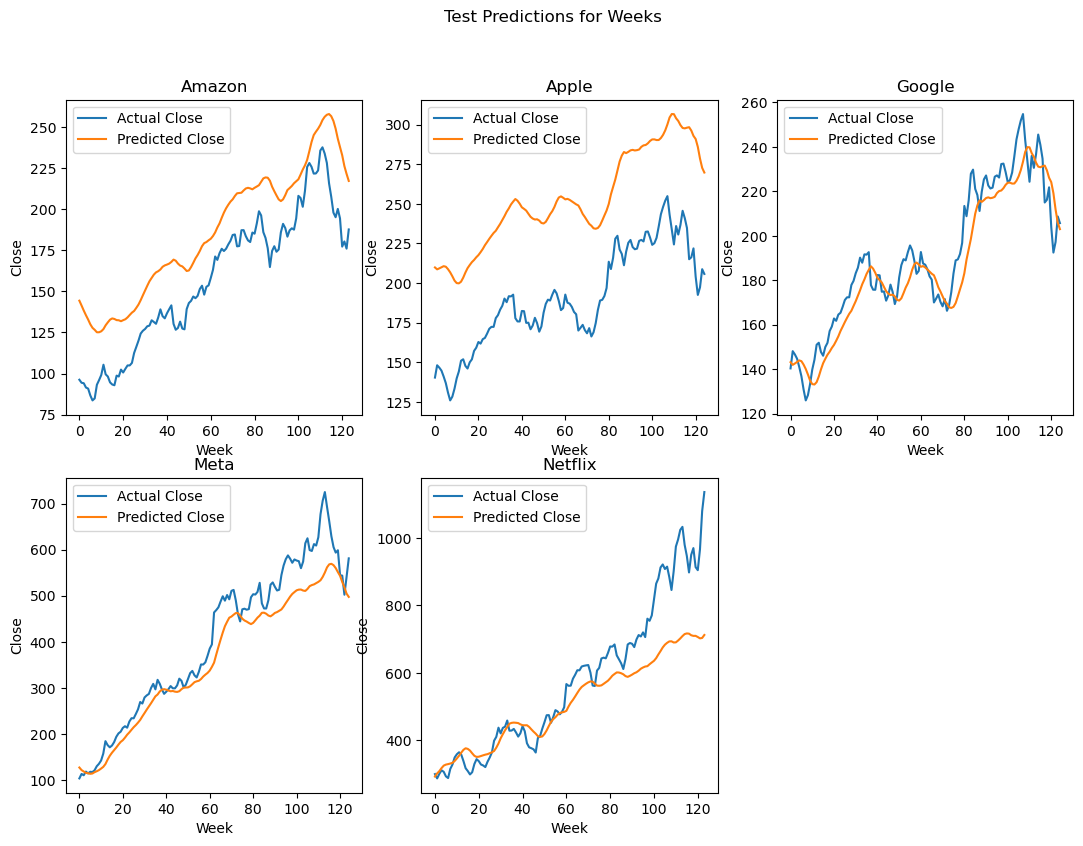

In [35]:
#Graphing Testing
plt.figure(figsize=(13,9))
plt.subplot(2,3,1)
plt.plot(y_test_week_am, label='Actual Close')
plt.plot(test_pred_week_am, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Amazon')
plt.legend()
plt.subplot(2,3,2)
plt.plot(y_test_week_ap, label='Actual Close')
plt.plot(test_pred_week_ap, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Apple')
plt.legend()
plt.subplot(2,3,3)
plt.plot(y_test_week_go, label='Actual Close')
plt.plot(test_pred_week_go, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Google')
plt.legend()
plt.subplot(2,3,4)
plt.plot(y_test_week_me, label='Actual Close')
plt.plot(test_pred_week_me, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Meta')
plt.legend()
plt.subplot(2,3,5)
plt.plot(y_test_week_ne, label='Actual Close')
plt.plot(test_pred_week_ne, label='Predicted Close')
plt.xlabel('Week')
plt.ylabel('Close')
plt.title('Netflix')
plt.legend()
plt.suptitle('Test Predictions for Weeks')
plt.show()

_____________________________________________________________________________________________________________________________________

In [89]:
best_days = LSTM(1,32,1,7,1,0.2)

In [90]:
#Choosing best number of epochs for daily model:
##Hyperparameters:
#change batch size to 32 in code above, didn't want to copy paste all the code preparing the data:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(best_days.parameters(), lr=learning_rate, weight_decay=0.001)

val_loss=[]
for epoch in range(num_epochs):
    train_one_epoch(best_days, epoch, optimizer, loss_function, train_loader) 
    val_loss.append(validate_one_epoch(best_days,loss_function, test_loader))

Epoch: 1
Batch 100, Average Loss: 0.1731817218
Batch 200, Average Loss: 0.0132281628
Batch 300, Average Loss: 0.0026400438

Validation loss:0.0190314911
**********************************************************

Epoch: 2
Batch 100, Average Loss: 0.0006504369
Batch 200, Average Loss: 0.0004439659
Batch 300, Average Loss: 0.0002628936

Validation loss:0.0119090630
**********************************************************

Epoch: 3
Batch 100, Average Loss: 0.0002467471
Batch 200, Average Loss: 0.0002073344
Batch 300, Average Loss: 0.0002207953

Validation loss:0.0101873586
**********************************************************

Epoch: 4
Batch 100, Average Loss: 0.0002096707
Batch 200, Average Loss: 0.0001962773
Batch 300, Average Loss: 0.0002141297

Validation loss:0.0079713054
**********************************************************

Epoch: 5
Batch 100, Average Loss: 0.0002004399
Batch 200, Average Loss: 0.0001654629
Batch 300, Average Loss: 0.0001525491

Validation loss:0.007061

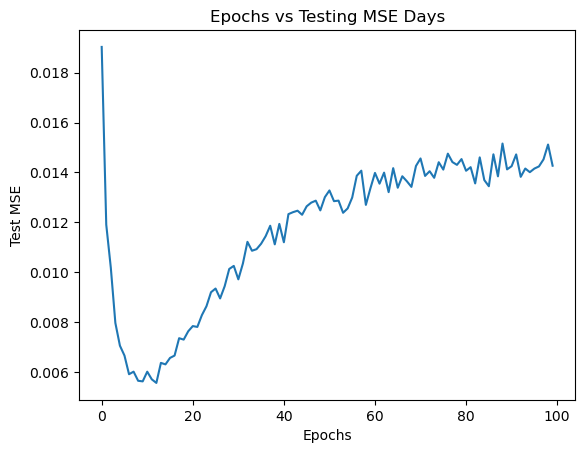

In [91]:
plt.plot(val_loss)
plt.title('Epochs vs Testing MSE Days')
plt.xlabel('Epochs')
plt.ylabel('Test MSE')
plt.show()

Starts overfitting after 10ish epochs, will train for 10 epochs. 
__________________________________________________________________________________________________________________________________________________________________________________

In [ ]:
best_week=LSTM(1,32,1,7,1,0.5)
#Training
##Hyperparameters:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(best_week.parameters(), lr=learning_rate, weight_decay=0.001)

val_loss_week=[]
for epoch in range(num_epochs):
    train_one_epoch(best_week,epoch, optimizer, loss_function, train_week_loader) 
    val_loss_week.append(validate_one_epoch(best_week, loss_function, test_week_loader))


Epoch: 1
Batch 100, Average Loss: 0.1921461986

Validation loss:0.0467243120
**********************************************************

Epoch: 2
Batch 100, Average Loss: 0.0061868316

Validation loss:0.0223068055
**********************************************************

Epoch: 3
Batch 100, Average Loss: 0.0021926545

Validation loss:0.0152465897
**********************************************************

Epoch: 4
Batch 100, Average Loss: 0.0012811539

Validation loss:0.0132088345
**********************************************************

Epoch: 5
Batch 100, Average Loss: 0.0009803182

Validation loss:0.0116538256
**********************************************************

Epoch: 6
Batch 100, Average Loss: 0.0008194476

Validation loss:0.0105169434
**********************************************************

Epoch: 7
Batch 100, Average Loss: 0.0007661068

Validation loss:0.0090823639
**********************************************************

Epoch: 8
Batch 100, Average Loss: 0.00078

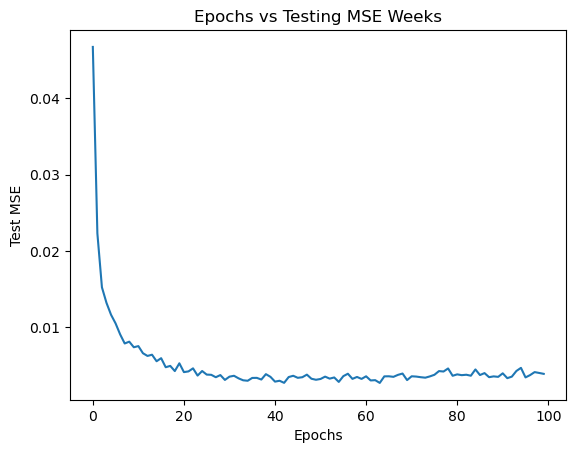

In [82]:
plt.plot(val_loss_week)
plt.title('Epochs vs Testing MSE Weeks')
plt.xlabel('Epochs')
plt.ylabel('Test MSE')
plt.show()

See downwords trend until maybe epoch 30ish, so will train for 30 epochs. 

**Will create final models in a different file so that they are easy to read since this file is very long.**